In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

import matplotlib
import matplotlib.pyplot as plt  # 파이플롯 사용
from IPython.display import set_matplotlib_formats
import seaborn as sns
sns.set_style('whitegrid')


set_matplotlib_formats('retina')  # 한글코드를 더 선명하게 해주는 조치, 레티나 설정
matplotlib.rc('font', family='AppleGothic') # 폰트 설정
matplotlib.rc('axes', unicode_minus=False) # 마이너스 폰트가 깨지는 경우가 있으므로 조치

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'This pattern has match groups')
warnings.filterwarnings('ignore', 'The iterable function was deprecated in Matplotlib')

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/TaewoongKong/code_sharing/master/2016%E1%84%82%E1%85%A7%E1%86%AB_%E1%84%80%E1%85%A5%E1%86%AB%E1%84%80%E1%85%A1%E1%86%BC%E1%84%80%E1%85%A5%E1%86%B7%E1%84%8C%E1%85%B5%E1%86%AB_%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5.csv")
df.head()

,기준년도,가입자일련번호,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg단위),허리둘레,시력(좌),시력(우),청력(좌),청력(우),수축기혈압,이완기혈압,식전혈당(공복혈당),총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진 수검여부,치아우식증유무,결손치유무,치아마모증유무,제3대구치(사랑니)이상,치석,데이터공개일자
0,2016,465969,1,8,41,170.0,70.0,74.0,0.7,0.7,1.0,1.0,118.0,70.0,85.0,194.0,97.0,54.0,120.0,14.6,2.0,1.1,31.0,36.0,96.0,3.0,NaN,1,NaN,NaN,NaN,NaN,2.0,20171219
1,2016,565871,1,10,41,160.0,60.0,81.0,1.2,1.0,1.0,1.0,134.0,84.0,105.0,143.0,84.0,33.0,93.0,16.2,1.0,1.0,20.0,23.0,14.0,1.0,NaN,0,NaN,NaN,NaN,NaN,NaN,20171219
2,2016,115718,2,11,11,160.0,55.0,71.0,1.0,1.0,1.0,1.0,129.0,85.0,86.0,203.0,52.0,51.0,141.0,14.0,1.0,0.8,17.0,14.0,20.0,1.0,NaN,1,NaN,NaN,NaN,NaN,0.0,20171219
3,2016,767524,1,6,28,180.0,70.0,79.0,1.0,0.9,1.0,1.0,137.0,78.0,92.0,154.0,53.0,55.0,94.0,14.6,1.0,1.0,21.0,23.0,16.0,1.0,NaN,0,NaN,NaN,NaN,NaN,NaN,20171219
4,2016,482178,2,9,11,160.0,60.0,85.0,0.8,1.2,1.0,1.0,92.0,60.0,90.0,239.0,148.0,46.0,163.0,10.3,1.0,0.9,17.0,12.0,13.0,1.0,NaN,1,NaN,NaN,NaN,NaN,0.0,20171219


## 조절효과 분석하기

- 독립변수 3개, 종속변수 1개
    - 독립변수 1 : 감마지피티
    - 독립변수 2 : 허리둘레
    - 독립변수 3 : 총콜레스테롤
    - 종속변수 : 수축기혈압


1. 성별코드를 조절효과로 넣어본다.

2. 흡연상태 (1,2,3)를 조절효과로 넣어본다.


In [32]:
def moderation_report(dependent_variable, moderation_variable, independent_variable, df, moderation_variable_type):

    # 필요한 패키지 import
    import statsmodels.formula.api as smf  # ols ANOVA를 진행할 statsmodels 패키지
    import scipy.stats  # 피어슨 상관계수를 계산할 scipy 패키지

    
    # 조절변수가 categorical 타입 (명목범주)인 경우 
    if moderation_variable_type == "cat":
        
        
        # 조절변수를 고려하지 않았을 때의 회귀분석
        regression_object_before_moderation = smf.ols(formula=f'{dependent_variable} ~ {independent_variable}', data=df).fit()

        # 조절변수를 고려한 회귀분석 : C(moderation_variable) 의 C는 categorical 변수라는 걸 지정해 준 것
        regression_object_after_moderation = smf.ols(formula=f'{dependent_variable} ~ C({moderation_variable}) * {independent_variable}', data=df).fit()

        
        # 각 회귀분석으로부터 수정된 결정계수(알스퀘어드)를 추출
        before_mod_adj_rsquared = regression_object_before_moderation.rsquared_adj
        after_mod_adj_rsquared = regression_object_after_moderation.rsquared_adj

        # 조절변수를 넣은 뒤 결정계수가 얼마나 변했는가? (조절변수를 구분에 대한 실효성 판단)
        if before_mod_adj_rsquared < after_mod_adj_rsquared:
            print(f"조절변수를 발라 낸 뒤 수정된 알스퀘어드가 {after_mod_adj_rsquared - before_mod_adj_rsquared}만큼 증가했다")
        else:
            print("조절변수를 발라 낸 뒤에도 수정된 알스퀘어드 값은 큰 변화가 없다.")


        # 패키지 클래스로부터 계산된 값을 각 변수에 담아줌. 회귀계수(베타값)와 표준오차 수집.
        
        # 절편값
        before_interception_coef = regression_object_before_moderation.params[0] 
        after_interception_coef = regression_object_after_moderation.params[0]
        before_interception_std_err = regression_object_before_moderation.bse[0]
        after_interception_std_err = regression_object_after_moderation.bse[0]

        # 독립변수
        before_ind_variable_coef = regression_object_before_moderation.params[0] 
        after_ind_variable_coef = regression_object_after_moderation.params[1]
        before_ind_variable_std_err = regression_object_before_moderation.bse[0]
        after_ind_variable_std_err = regression_object_after_moderation.bse[1]

        # 조절변수
        after_mod_variable_coef = regression_object_after_moderation.params[1]
        after_mod_variable_std_err = regression_object_after_moderation.bse[1]

        # 교호작용 (상호작용항)
        after_ind_and_mod_variable_coef = regression_object_after_moderation.params[3]
        after_ind_and_mod_variable_std_err = regression_object_after_moderation.bse[3]




        result = {   
            "조절변수 고려 전 절편 값의 회귀계수(베타값)" : before_interception_coef,
            "조절변수 고려 후 절편 값의 회귀계수(베타값)" : after_interception_coef,
            "조절변수 고려 전 절편 값의 표준오차" : before_interception_std_err,
            "조절변수 고려 후 절편 값의 표준오차" : after_interception_std_err,

            "조절변수 고려 전 독립변수의 회귀계수(베타값)" : before_ind_variable_coef,
            "조절변수 고려 후 독립변수의 회귀계수(베타값)" : after_ind_variable_coef,
            "조절변수 고려 전 독립변수의 표준오차" : before_ind_variable_std_err,
            "조절변수 고려 후 독립변수의 표준오차" :after_ind_variable_std_err,

            "조절변수 고려 후 조절변수의 회귀계수(베타값)" : after_mod_variable_coef,
            "조절변수 고려 후 조절변수의 표준오차" : after_mod_variable_std_err,

            "조절변수 고려 후 상호작용항(교호작용)의 회귀계수(베타값)" : after_ind_and_mod_variable_coef,
            "조절변수 고려 후 상호작용항(교호작용)의 표준오차" : after_ind_and_mod_variable_std_err
                }

        # 보기 좋게 데이터프레임으로 추출
        result_df = pd.DataFrame.from_dict(result, orient='index')
        result_df.columns = ['결과비교']


        # 카테고리컬 조절변수의 시각화 진행
        plt.figure(figsize=(8, 8))
        plt.scatter(df[independent_variable], df[dependent_variable], alpha=0.3)
        plt.xlabel(independent_variable)
        plt.ylabel(dependent_variable)

        independent_variable_linspace = np.linspace(df[independent_variable].min(), df[independent_variable].max(), 100)
        
        # 조절변수 고려하지 않은 경우의 회귀선
        plt.plot(independent_variable_linspace,
                 regression_object_before_moderation.params[0] 
                 + regression_object_before_moderation.params[1] * independent_variable_linspace,  # 독립변수와 회귀계수 단독 항
                 'b',  # 회귀선 색깔
                 label = "조절변수 적용하지 않음",
                 ls="--")

        # 조절변수를 넣되 카테고리컬 데이터를 단순히 더미변수로 얹은 경우의 회귀선
        plt.plot(independent_variable_linspace,
                 regression_object_after_moderation.params[0] 
                 + regression_object_after_moderation.params[1] * 0  # 조절변수와 회귀계수 단독 항
                 + regression_object_after_moderation.params[2] * independent_variable_linspace  # 독립변수와 회귀계수 단독 항
                 + regression_object_after_moderation.params[3] * 0 * independent_variable_linspace,  # 상호작용항
                 'g',  # 회귀선 색깔
                 label=f"categorical 조절변수인 {moderation_variable}가 절편값에만 영향을 주는 경우 (절편 + 1)")


        # 조절변수가 기존 회귀계수와 상호작용한 경우의 회귀선
        plt.plot(independent_variable_linspace,
                 regression_object_after_moderation.params[0]
                 + regression_object_after_moderation.params[1] * 1
                 + regression_object_after_moderation.params[2] * independent_variable_linspace
                 + regression_object_after_moderation.params[3] * 1 * independent_variable_linspace,
                 'r',  # 회귀선 색깔
                 label=f"조절변수인 {moderation_variable}가 절편값과 교호작용까지 영향을 준 경우")

        plt.legend(loc=2)
        plt.show
        return result_df
    
    ######################################
    
    # 조절변수가 numeric 타입 (수치형 범주)인 경우 
    elif moderation_variable_type == "numeric":
        
        
        # 조절변수를 고려하지 않았을 때의 회귀분석
        regression_object_before_moderation = smf.ols(formula=f'{dependent_variable} ~ {independent_variable}', data=df).fit()

        
        # 조절변수를 고려한 회귀분석
        regression_object_after_moderation = smf.ols(formula=f'{dependent_variable} ~ {moderation_variable} * {independent_variable}', data=df).fit()


        before_mod_adj_rsquared = regression_object_before_moderation.rsquared_adj
        after_mod_adj_rsquared = regression_object_after_moderation.rsquared_adj

        if before_mod_adj_rsquared < after_mod_adj_rsquared:
            print(f"조절변수를 발라 낸 뒤 수정된 알스퀘어드가 {after_mod_adj_rsquared - before_mod_adj_rsquared}만큼 증가했다")
        else:
            print("조절변수를 발라 낸 뒤에도 수정된 알스퀘어드 값은 큰 변화가 없다.")



        before_interception_coef = regression_object_before_moderation.params[0]
        after_interception_coef = regression_object_after_moderation.params[0]
        before_interception_std_err = regression_object_before_moderation.bse[0]
        after_interception_std_err = regression_object_after_moderation.bse[0]


        before_ind_variable_coef = regression_object_before_moderation.params[0]
        after_ind_variable_coef = regression_object_after_moderation.params[1]
        before_ind_variable_std_err = regression_object_before_moderation.bse[0]
        after_ind_variable_std_err = regression_object_after_moderation.bse[1]


        after_mod_variable_coef = regression_object_after_moderation.params[1]
        after_mod_variable_std_err = regression_object_after_moderation.bse[1]


        after_ind_and_mod_variable_coef = regression_object_after_moderation.params[3]
        after_ind_and_mod_variable_std_err = regression_object_after_moderation.bse[3]




        result = {   
            "조절변수 고려 전 절편 값의 회귀계수(베타값)" : before_interception_coef,
            "조절변수 고려 후 절편 값의 회귀계수(베타값)" : after_interception_coef,
            "조절변수 고려 전 절편 값의 표준오차" : before_interception_std_err,
            "조절변수 고려 후 절편 값의 표준오차" : after_interception_std_err,

            "조절변수 고려 전 독립변수의 회귀계수(베타값)" : before_ind_variable_coef,
            "조절변수 고려 후 독립변수의 회귀계수(베타값)" : after_ind_variable_coef,
            "조절변수 고려 전 독립변수의 표준오차" : before_ind_variable_std_err,
            "조절변수 고려 후 독립변수의 표준오차" :after_ind_variable_std_err,

            "조절변수 고려 후 조절변수의 회귀계수(베타값)" : after_mod_variable_coef,
            "조절변수 고려 후 조절변수의 표준오차" : after_mod_variable_std_err,

            "조절변수 고려 후 상호작용항(교호작용)의 회귀계수(베타값)" : after_ind_and_mod_variable_coef,
            "조절변수 고려 후 상호작용항(교호작용)의 표준오차" : after_ind_and_mod_variable_std_err
                }




        # numeric 조절변수의 시각화 진행

        # 조절변수의 값들을 정리해서 리스트에 담음
        moderation_variable_list = df[moderation_variable].value_counts().index.to_list()
        moderation_variable_list.sort()

        # 조절변수의 값들을 하나씩 시각화하여 조절변수에 따라 회귀계수가 어떻게 바뀌는지 파악
        figure, axs = plt.subplots(figsize=(20, 8), nrows=1, ncols=len(moderation_variable_list))
        plt.xlabel(independent_variable)
        plt.ylabel(dependent_variable)

        # 조절변수 값의 종류들마다 for문을 돌려 그래프 그림
        for num, value in enumerate(moderation_variable_list):
            
            
            # 조절변수 값에 소속된 데이터를 두고 독립변수와 종속변수 간의 결정계수를 구함. 결정계수는 피어슨 r 상관계수를 제곱하는 것으로 계산.
            # 수정된 결정계수는 구하지 못함
            pearsonr, pvalue = scipy.stats.pearsonr(df.loc[df[moderation_variable] == value, dependent_variable], df.loc[df[moderation_variable] == value, independent_variable])
            rsquared = pearsonr*pearsonr  # 알스퀘어드 = 피어슨 r 상관계수의 제곱

            if pvalue < 0.05:  # 독립~종속 변수의 상관관계에 해당 조절변수의 조절효과가 주는 영향이 통계적으로 유의미한지 파악
                print(f'조절변수인 {moderation_variable}가 {value}일 때의 조절효과는 통계적으로 유의함 확인')
                result[f'조절변수인 {moderation_variable}가 {value}일 때 알스퀘어드'] = rsquared
            else:
                print(f'조절변수인 {moderation_variable}가 {value}일 때의 조절효과는 통계적으로 유의하지 못함')
                result[f'조절변수인 {moderation_variable}가 {value}일 때 알스퀘어드'] = rsquared
            
            # 회귀선 그리기
            sns.regplot(x=dependent_variable,
                        y=independent_variable,
                        data=df.loc[df[moderation_variable] == value],
                        ax = axs[num])
            axs[num].set_title(f"{moderation_variable}가 {value}일 때의 회귀분석")

            
        result_df = pd.DataFrame.from_dict(result, orient='index')
        result_df.columns = ['결과비교']
        return result_df
    
    else:
        print("moderation_variable_type 파라미터 선택이 잘못되었습니다. 'cat' 혹은 'numeric'을 기입하세요")
    

조절변수를 발라 낸 뒤 수정된 알스퀘어드가 0.001310985750436089만큼 증가했다
조절변수인 흡연상태가 1.0일 때의 조절효과는 통계적으로 유의하지 못함
조절변수인 흡연상태가 2.0일 때의 조절효과는 통계적으로 유의하지 못함
조절변수인 흡연상태가 3.0일 때의 조절효과는 통계적으로 유의함 확인


,결과비교
조절변수 고려 전 절편 값의 회귀계수(베타값),116.975433
조절변수 고려 후 절편 값의 회귀계수(베타값),119.503158
조절변수 고려 전 절편 값의 표준오차,2.343045
조절변수 고려 후 절편 값의 표준오차,5.117074
조절변수 고려 전 독립변수의 회귀계수(베타값),116.975433
조절변수 고려 후 독립변수의 회귀계수(베타값),-1.725467
조절변수 고려 전 독립변수의 표준오차,2.343045
조절변수 고려 후 독립변수의 표준오차,2.851092
조절변수 고려 후 조절변수의 회귀계수(베타값),-1.725467
조절변수 고려 후 조절변수의 표준오차,2.851092


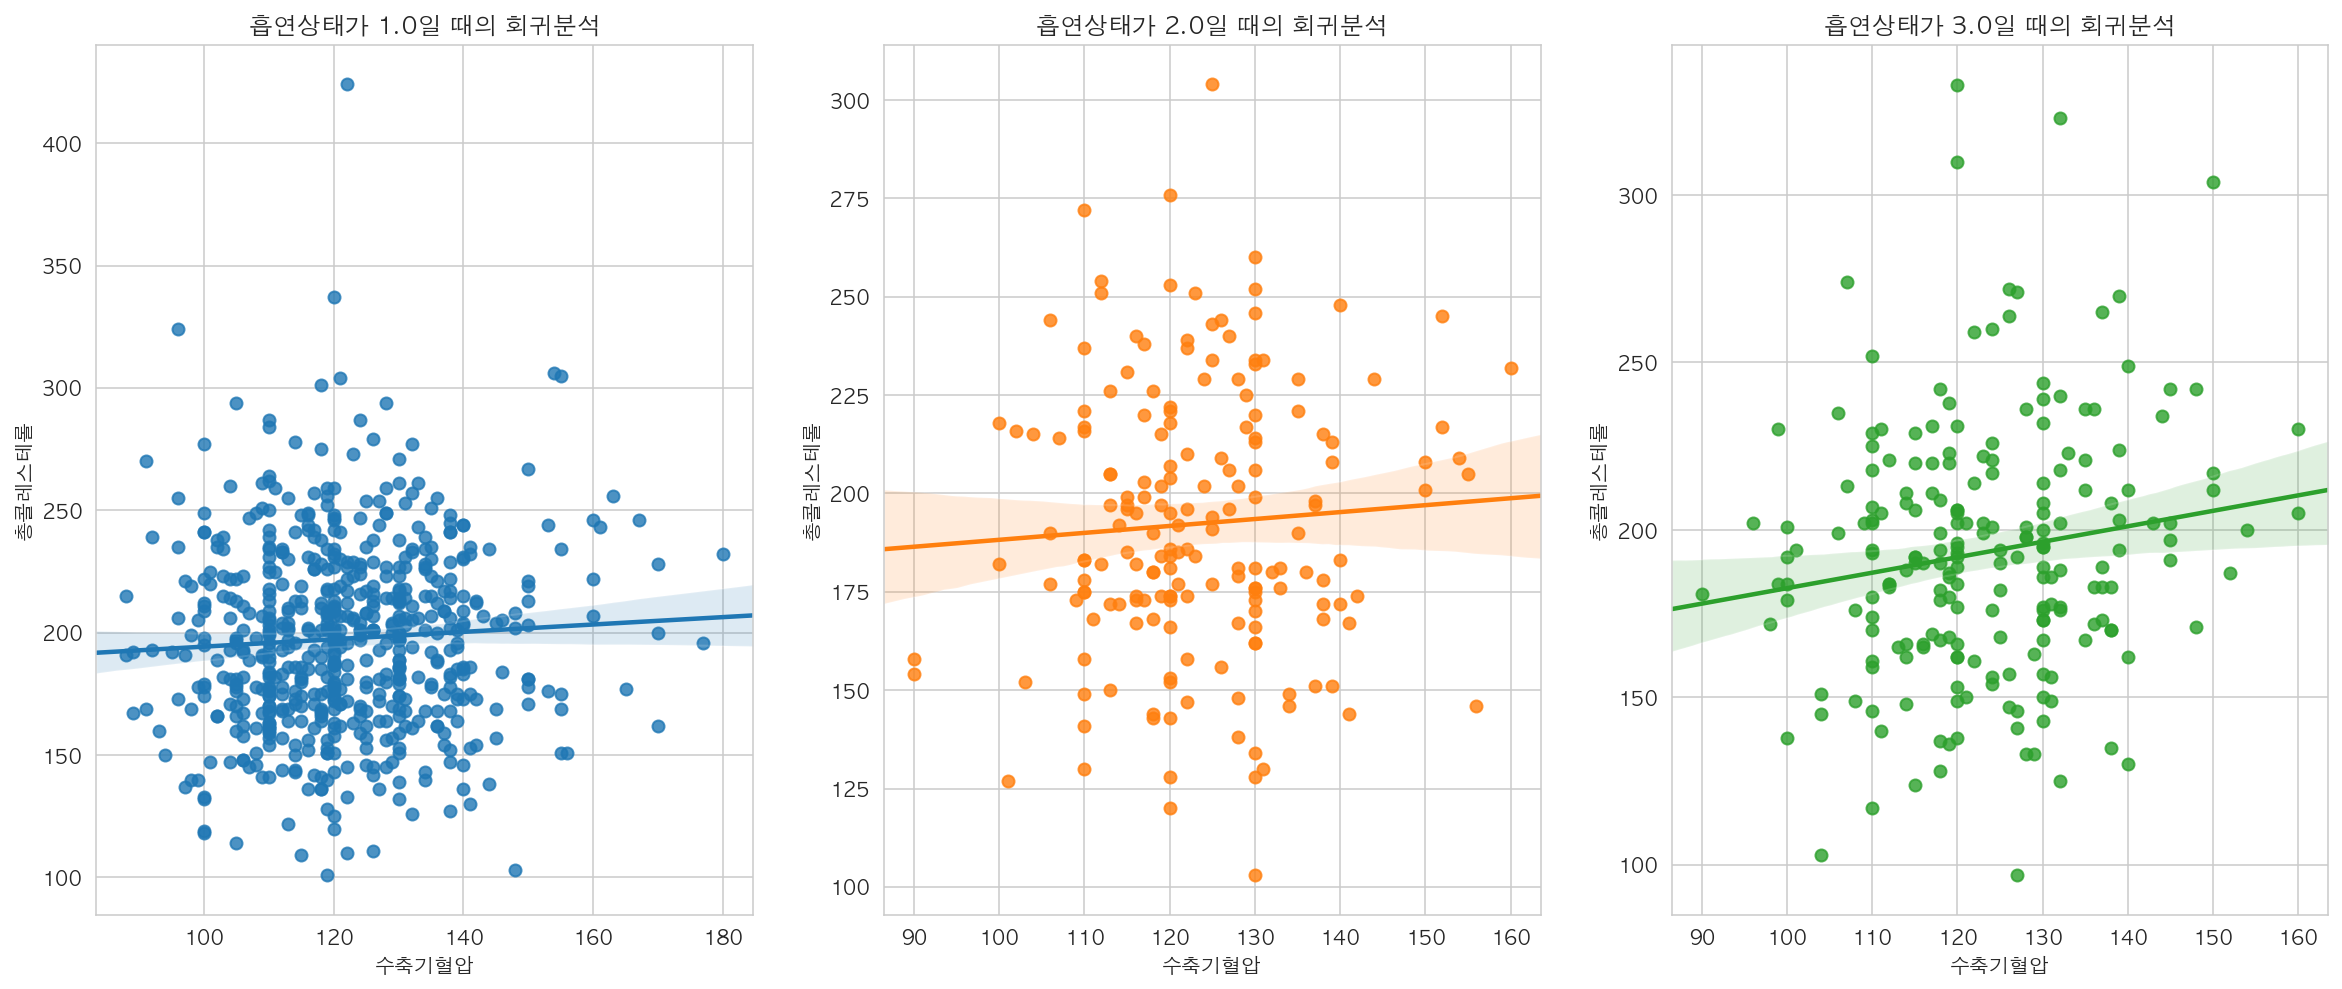

In [33]:
moderation_report('수축기혈압', '흡연상태', '총콜레스테롤', df, "numeric")

조절변수를 발라 낸 뒤 수정된 알스퀘어드가 0.015703356263055746만큼 증가했다


,결과비교
조절변수 고려 전 절편 값의 회귀계수(베타값),116.975433
조절변수 고려 후 절편 값의 회귀계수(베타값),119.391771
조절변수 고려 전 절편 값의 표준오차,2.343045
조절변수 고려 후 절편 값의 표준오차,3.225369
조절변수 고려 전 독립변수의 회귀계수(베타값),116.975433
조절변수 고려 후 독립변수의 회귀계수(베타값),-5.624714
조절변수 고려 전 독립변수의 표준오차,2.343045
조절변수 고려 후 독립변수의 표준오차,4.654760
조절변수 고려 후 조절변수의 회귀계수(베타값),-5.624714
조절변수 고려 후 조절변수의 표준오차,4.654760


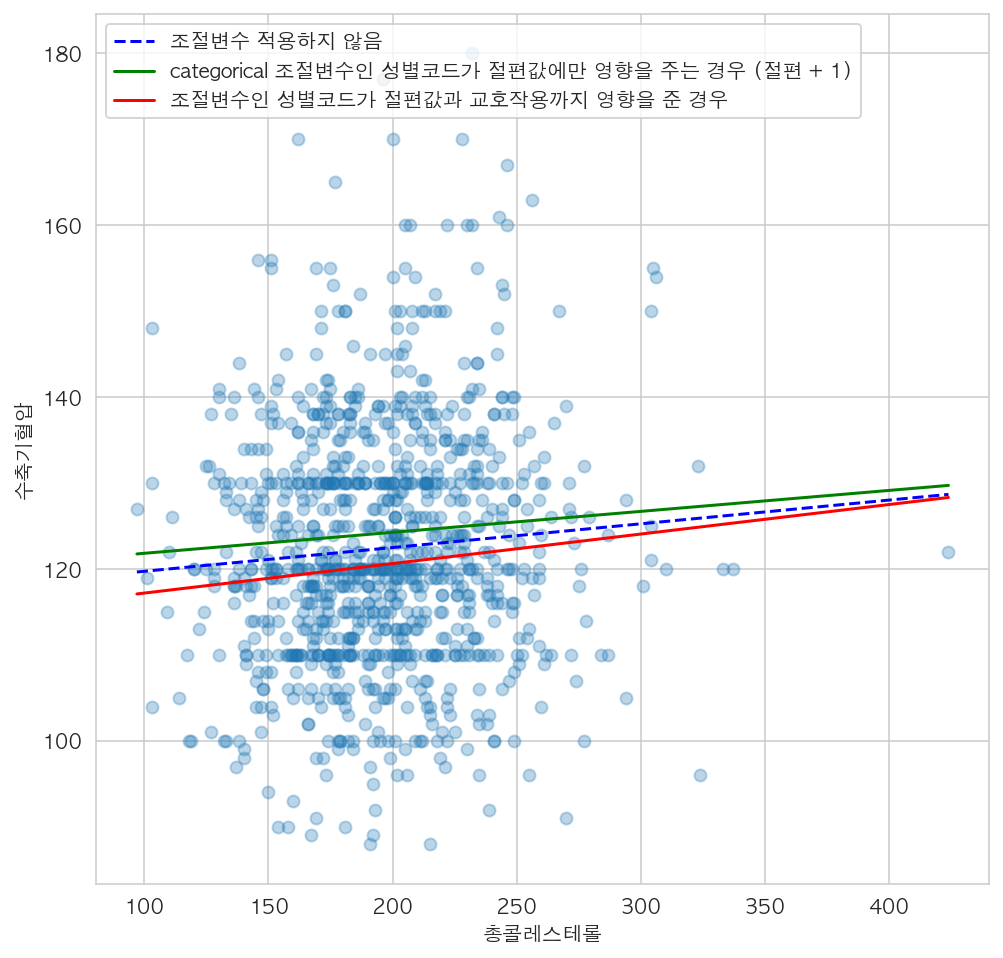

In [34]:
moderation_report('수축기혈압', '성별코드', '총콜레스테롤', df, "cat")

조절변수를 발라 낸 뒤 수정된 알스퀘어드가 0.06896034017157449만큼 증가했다


,결과비교
조절변수 발라내기 전 절편 값의 회귀계수(베타값),21.677201
조절변수 발래낸 뒤 절편 값의 회귀계수(베타값),26.095024
조절변수 발라내기 전 절편 값의 표준오차,9.331660
조절변수 발래낸 뒤 절편 값의 표준오차,12.492980
조절변수 발라내기 전 독립변수의 회귀계수(베타값),0.077936
조절변수 발라낸 뒤 독립변수의 회귀계수(베타값),0.128438
조절변수 발라내기 전 독립변수의 표준오차,0.046830
조절변수 발라낸 뒤 독립변수의 표준오차,0.063062
조절변수 발라낸 뒤 조절변수의 회귀계수(베타값),-14.100218
조절변수 발라낸 뒤 조절변수의 표준오차,18.029506


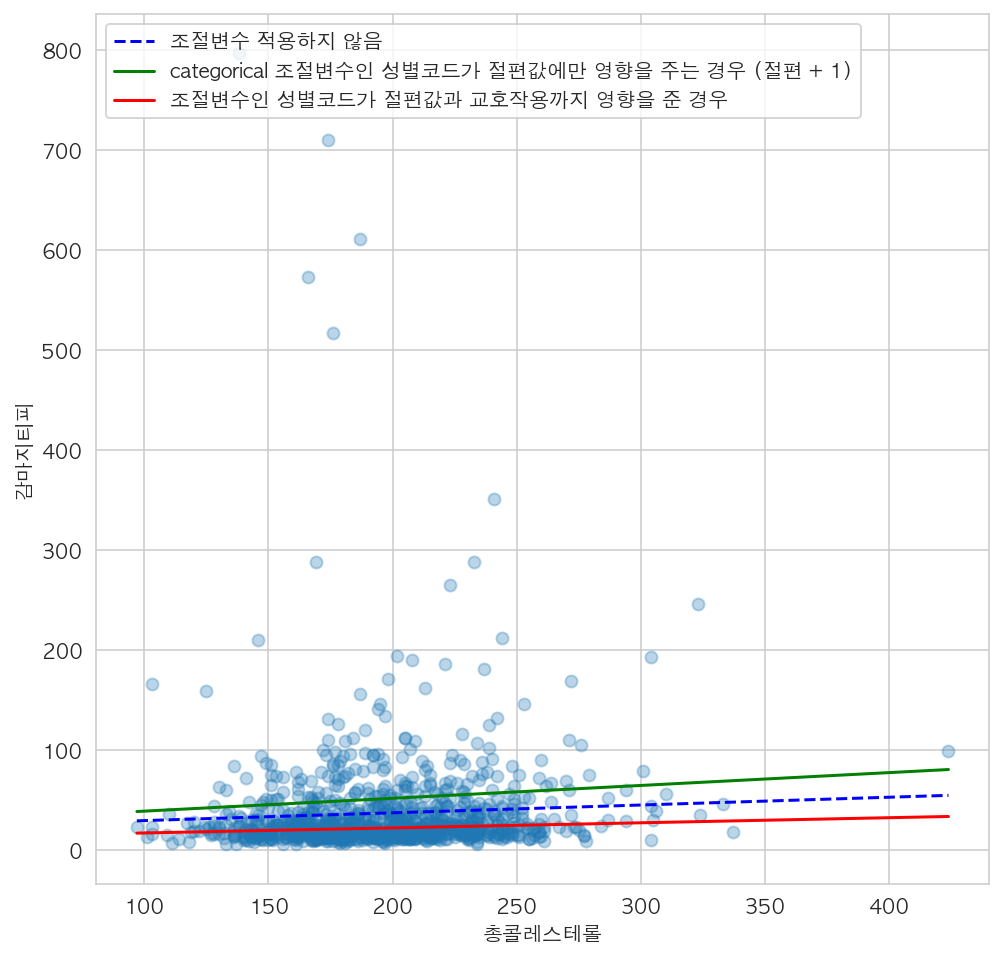

In [12]:
moderation_report('감마지티피', '성별코드', '총콜레스테롤', df, "cat")

조절변수를 발라 낸 뒤 수정된 알스퀘어드가 0.05691459961524903만큼 증가했다
조절변수인 흡연상태가 1.0일 때의 조절효과는 통계적으로 유의함 확인
조절변수인 흡연상태가 2.0일 때의 조절효과는 통계적으로 유의하지 못함
조절변수인 흡연상태가 3.0일 때의 조절효과는 통계적으로 유의하지 못함


,결과비교
조절변수 발라내기 전 절편 값의 회귀계수(베타값),21.677201
조절변수 발래낸 뒤 절편 값의 회귀계수(베타값),-24.717680
조절변수 발라내기 전 절편 값의 표준오차,9.331660
조절변수 발래낸 뒤 절편 값의 표준오차,19.803341
조절변수 발라내기 전 독립변수의 회귀계수(베타값),0.077936
조절변수 발라낸 뒤 독립변수의 회귀계수(베타값),0.180919
조절변수 발라내기 전 독립변수의 표준오차,0.046830
조절변수 발라낸 뒤 독립변수의 표준오차,0.098938
조절변수 발라낸 뒤 조절변수의 회귀계수(베타값),26.698312
조절변수 발라낸 뒤 조절변수의 표준오차,11.033873


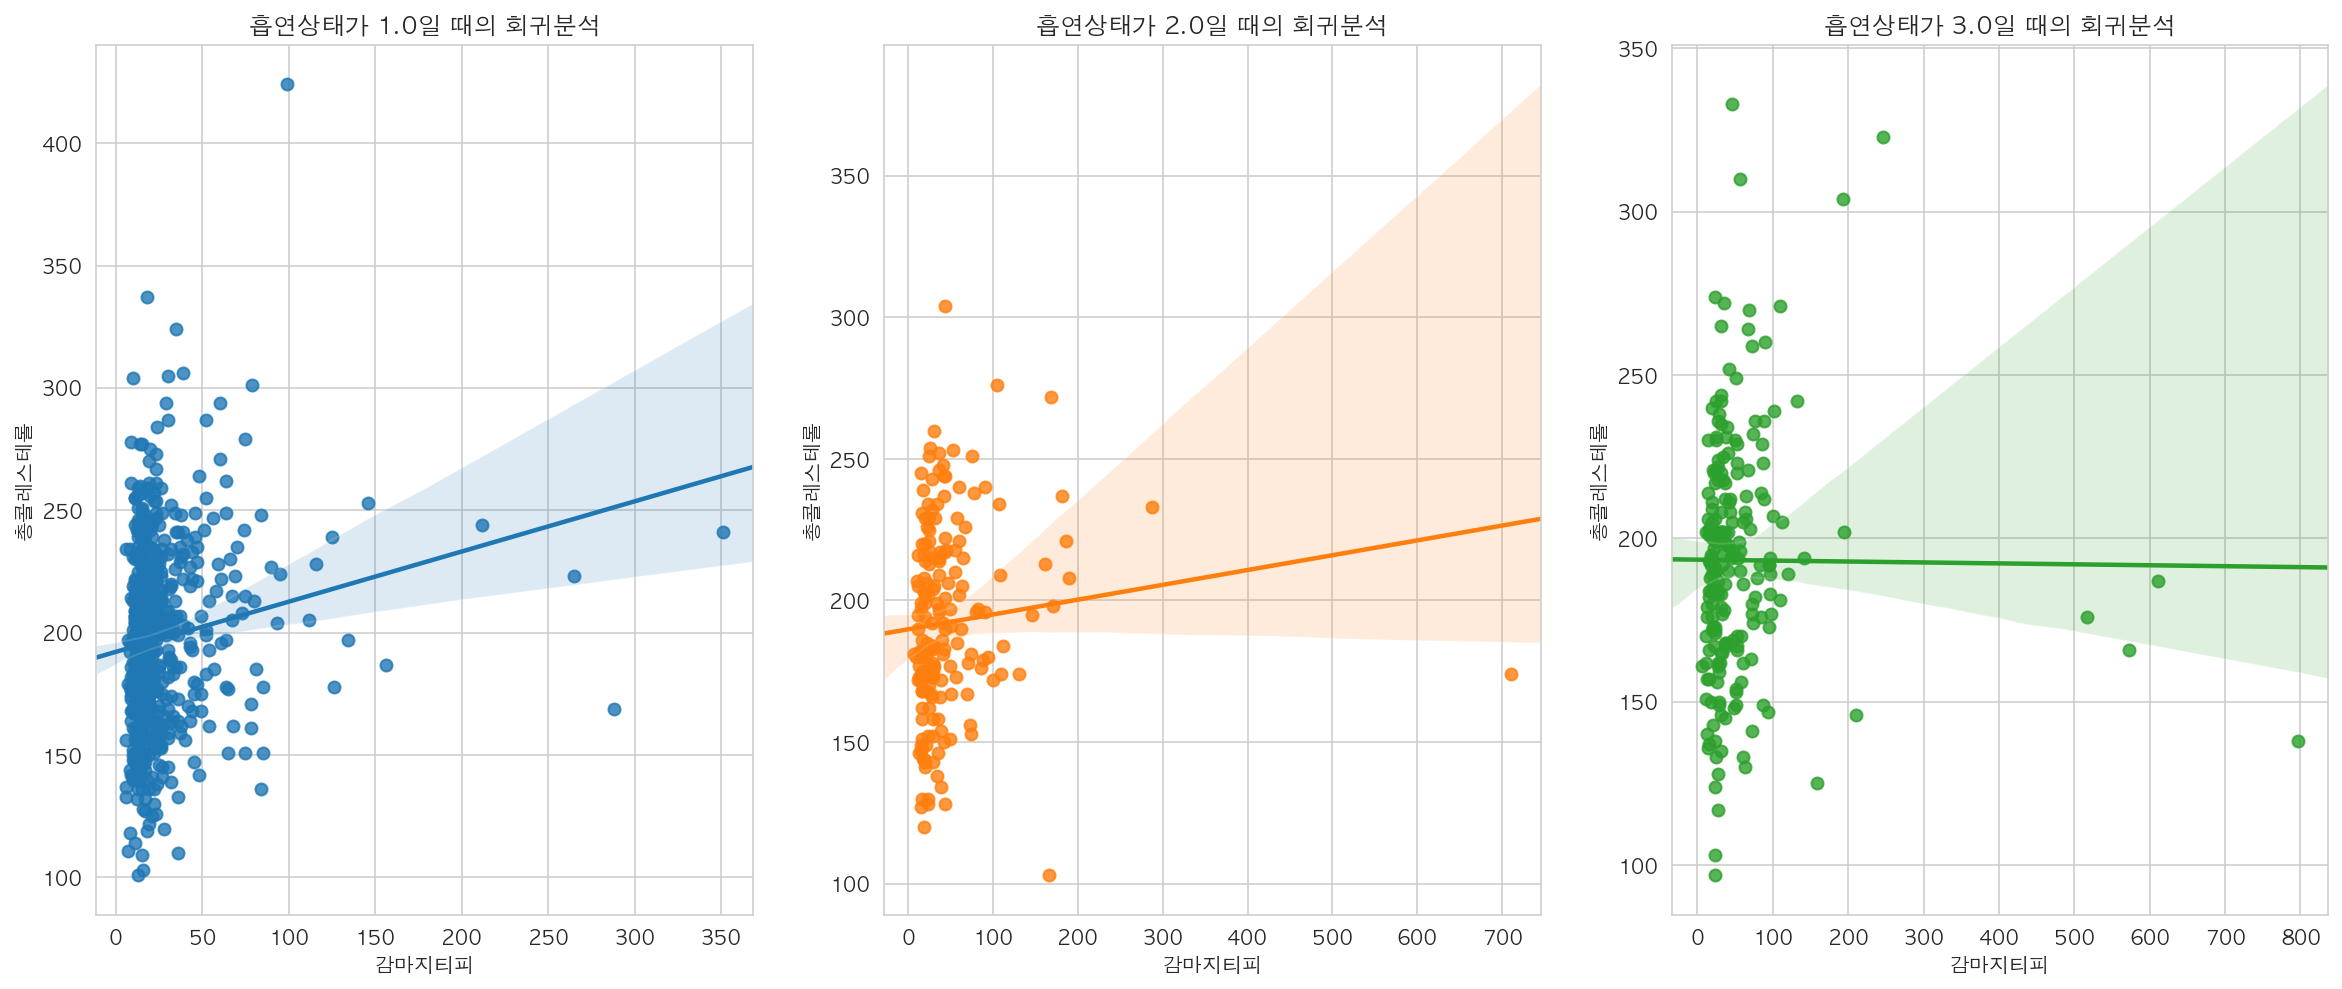

In [13]:
moderation_report('감마지티피', '흡연상태', '총콜레스테롤', df, "numeric")

In [14]:
df['요단백'].value_counts()

1.0    941
2.0     32
3.0     15
4.0      4
Name: 요단백, dtype: int64

조절변수를 발라 낸 뒤에도 수정된 알스퀘어드 값은 큰 변화가 없다.
조절변수인 요단백가 1.0일 때의 조절효과는 통계적으로 유의하지 못함
조절변수인 요단백가 2.0일 때의 조절효과는 통계적으로 유의하지 못함
조절변수인 요단백가 3.0일 때의 조절효과는 통계적으로 유의하지 못함
조절변수인 요단백가 4.0일 때의 조절효과는 통계적으로 유의하지 못함


,결과비교
조절변수 발라내기 전 절편 값의 회귀계수(베타값),21.677201
조절변수 발래낸 뒤 절편 값의 회귀계수(베타값),8.409861
조절변수 발라내기 전 절편 값의 표준오차,9.331660
조절변수 발래낸 뒤 절편 값의 표준오차,29.249905
조절변수 발라내기 전 독립변수의 회귀계수(베타값),0.077936
조절변수 발라낸 뒤 독립변수의 회귀계수(베타값),0.141853
조절변수 발라내기 전 독립변수의 표준오차,0.046830
조절변수 발라낸 뒤 독립변수의 표준오차,0.139267
조절변수 발라낸 뒤 조절변수의 회귀계수(베타값),12.553094
조절변수 발라낸 뒤 조절변수의 표준오차,25.737890


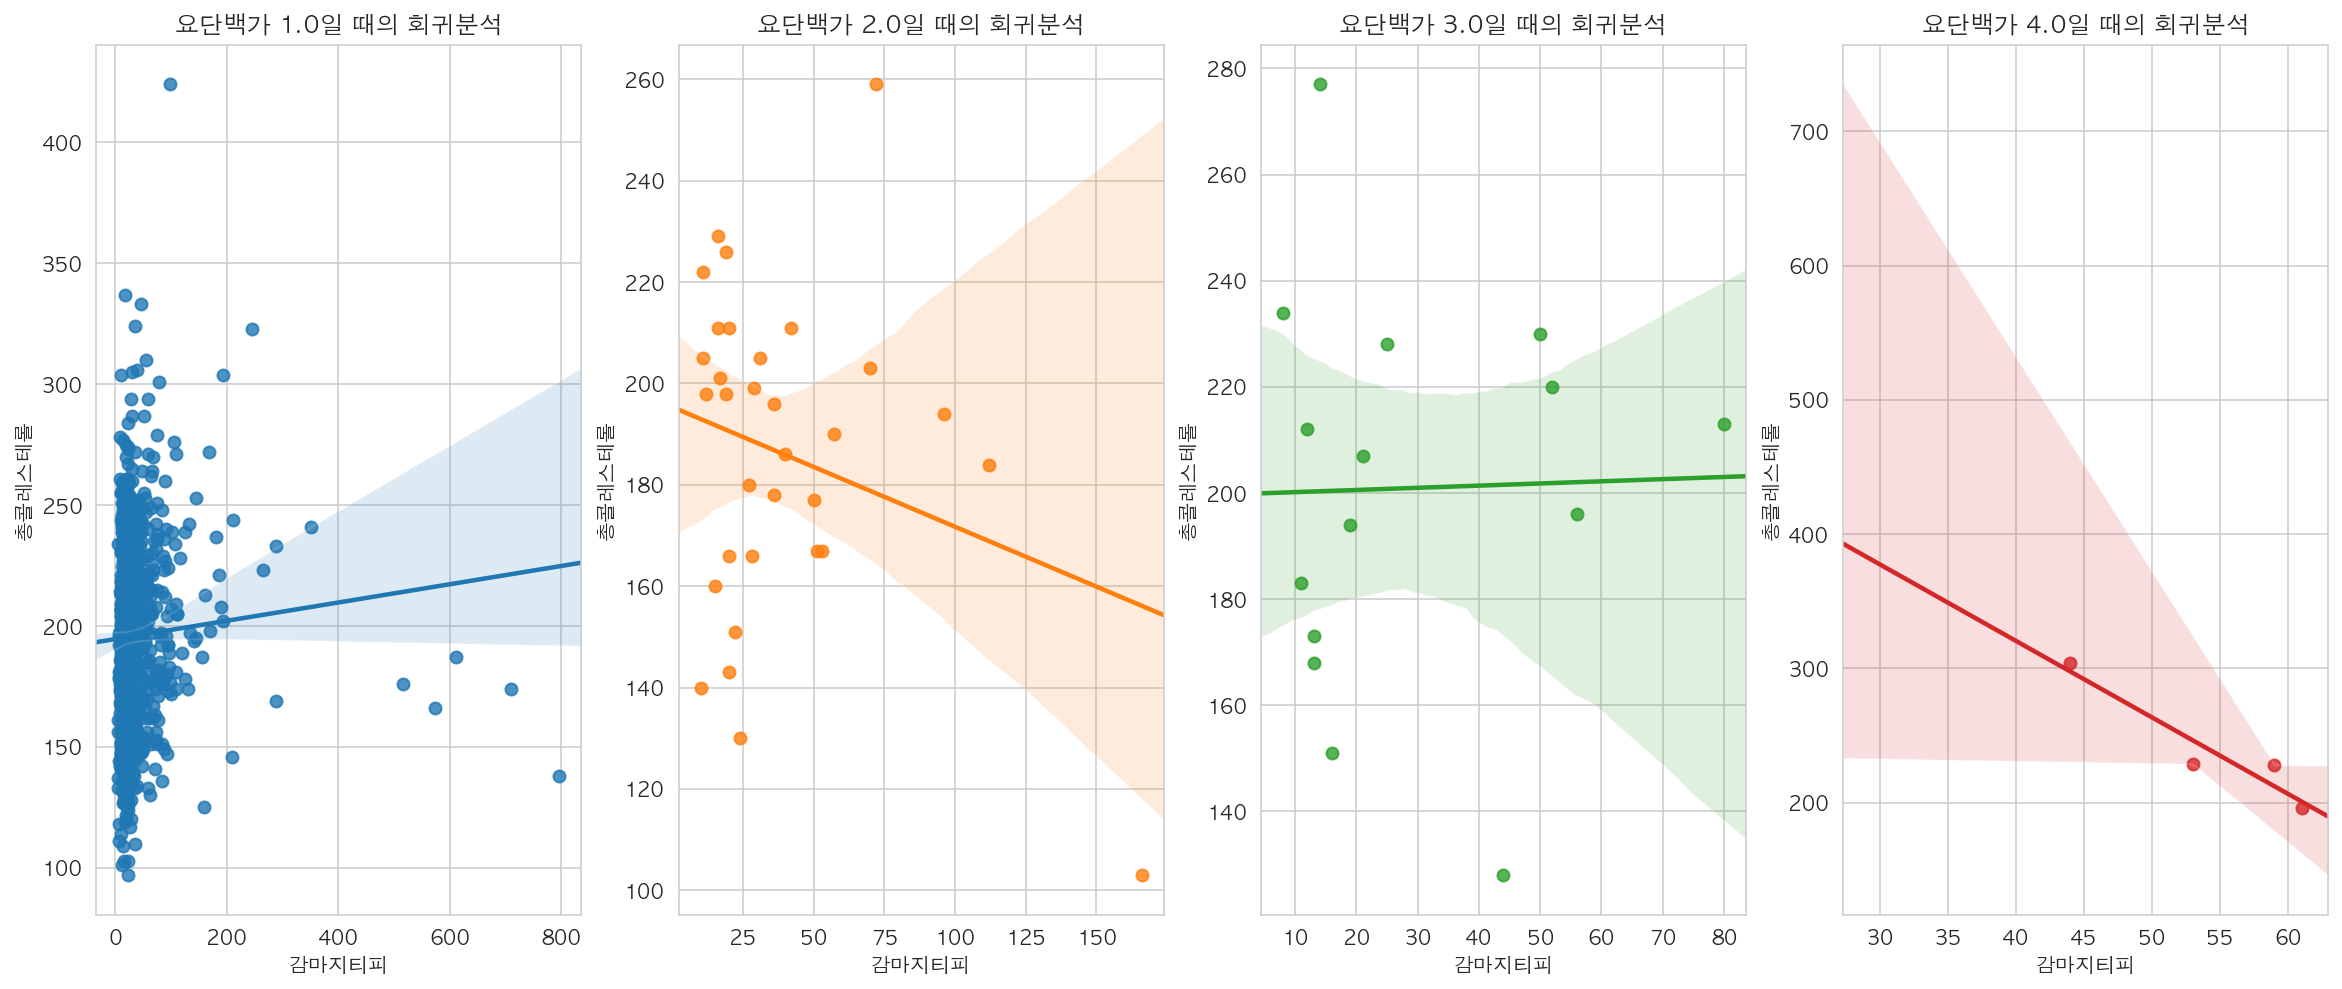

In [15]:
moderation_report('감마지티피', '요단백', '총콜레스테롤', df, "numeric")

In [19]:
import statsmodels.formula.api as smf  # ols ANOVA를 진행할 statsmodels 패키지


dependent_variable = '수축기혈압'
moderation_variable = '성별코드'
independent_variable = '총콜레스테롤'

regression_object_before_moderation = smf.ols(formula=f'{dependent_variable} ~ {independent_variable}', data=df).fit()
regression_object_after_moderation = smf.ols(formula=f'{dependent_variable} ~ C({moderation_variable}) * {independent_variable}', data=df).fit()


before_interception_coef = regression_object_before_moderation.params[0]
after_interception_coef = regression_object_after_moderation.params[0]
before_interception_std_err = regression_object_before_moderation.bse[0]
after_interception_std_err = regression_object_after_moderation.bse[0]


before_ind_variable_coef = regression_object_before_moderation.params[0]
after_ind_variable_coef = regression_object_after_moderation.params[1]
before_ind_variable_std_err = regression_object_before_moderation.bse[0]
after_ind_variable_std_err = regression_object_after_moderation.bse[1]


after_mod_variable_coef = regression_object_after_moderation.params[1]
after_mod_variable_std_err = regression_object_after_moderation.bse[1]


after_ind_and_mod_variable_coef = regression_object_after_moderation.params[3]
after_ind_and_mod_variable_std_err = regression_object_after_moderation.bse[3]
